[View in Colaboratory](https://colab.research.google.com/github/MChamith/SpatioAE/blob/master/trainae.ipynb)

In [1]:
!git clone https://github.com/MChamith/SpatioAE

Cloning into 'SpatioAE'...
remote: Counting objects: 7124, done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 7124 (delta 28), reused 0 (delta 0), pack-reused 7076
Receiving objects: 100% (7124/7124), 220.04 MiB | 29.74 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Checking out files: 100% (7204/7204), done.


In [0]:

from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras import backend as K
import cv2
import numpy as np
import os
from tqdm import tqdm
import fnmatch
import scipy.misc
from keras.models import load_model

TRAIN_DIR ='SpatioAE/Train'
TEST_DIR = 'SpatioAE/Test'
IMG_SIZE = 128



def create_training_set():
  train_data = []
  matches = []
  for root, dirnames, filenames in tqdm(os.walk(TRAIN_DIR)):
    for filename in fnmatch.filter(filenames, "*.tif"):
      path = os.path.join(root, filename)
      img = image.load_img(path, target_size=(128,128), grayscale = True)
      img_array = image.img_to_array(img)
#       print("img array size is " + str(img_array.shape))
#       img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#       img_array = np.expand_dims(img_array, axis = 2)
      train_data.append(np.array(img_array))
          
  np.save('training_data.npy' , train_data)
  
  return train_data

      
    
    
#   for img in tqdm(os.listdir(TRAIN_DIR)):
#     path = os.path.join(TRAIN_DIR, img)
#     img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#     img = np.expand_dims(img, axis = 2)
#     train_data.append(np.array(img))
    
    
#   np.save('training_data.npy' , train_data)
  
#   return train_data


def create_test_set():
  test_data = []
  for img in tqdm(os.listdir(TEST_DIR)):
    path = os.path.join(TEST_DIR, img)
    img = image.load_img(path, target_size=(128,128), grayscale = True)
    img_array =image.img_to_array(img)
    
#     img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#     img = np.expand_dims(img, axis = 2)
    test_data.append(np.array(img_array))
    
    
  np.save('test_data.npy' , test_data)
  return test_data

In [0]:
def strided_axis0(a, L): 
    # INPUTS :
    # a is array
    # L is length of array along axis=0 to be cut for forming each subarray

    # Length of 3D output array along its axis=0
    nd0 = a.shape[0] - L + 1

    # Store shape and strides info
    m,n = a.shape
    s0,s1 = a.strides

    # Finally use strides to get the 3D array view
    return np.lib.stride_tricks.as_strided(a, shape=(nd0,L,n), strides=(s0,s0,s1))

In [0]:
def create_cuboid(input_imgs):
  
  win_size = 16
  m = input_imgs.shape[0]
  h = input_imgs.shape[1]
  w = input_imgs.shape[2]
  c = input_imgs.shape[3]
  
  a = []                                    # a python list to hold the windows
  for i in range(0, input_imgs.shape[0]-win_size+1):
    window = input_imgs[i:i+win_size,:,:,:].reshape((-1,h,w,c)) # each individual window
    a.append(window)
   
#   cuboid = np.hstack(a)
  np.save('hyper_cuboid.npy' , a)
  return a

  
  

In [0]:
def create_test_cuboid(input_imgs):
  
  win_size = 16
  m = input_imgs.shape[0]
  h = input_imgs.shape[1]
  w = input_imgs.shape[2]
  c = input_imgs.shape[3]
  
  t = []                                    # a python list to hold the windows
  for i in range(0, input_imgs.shape[0]-win_size+1):
    window = input_imgs[i:i+win_size,:,:,:].reshape((-1,h,w,c)) # each individual window
    t.append(window)
   
#   cuboid = np.hstack(a)
  np.save('test_hyper_cuboid.npy' , t)
  return t

In [5]:
create_training_set()
input_data = np.load('training_data.npy')
input_data = input_data.astype('float32') / 255.
create_cuboid(input_data)
img_cuboids = np.load('hyper_cuboid.npy')
print(img_cuboids.shape)


35it [00:06,  5.42it/s]


(6785, 16, 128, 128, 1)


In [0]:

def model_autoencoder():
  
  input_img  = Input(shape = (16,128,128,1))  #channel last
  
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(input_img)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2))(x)
  print("layer one conv " + str(x.shape))
  
  x = Conv3D(filters = 48, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2))(x)
  print("layer two conv " + str(x.shape))
  
 
  x = Conv3D(filters = 64, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2))(x)
  print("layer three conv " + str(x.shape))
  
  x = Conv3D(filters = 64, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  encoded = MaxPooling3D(pool_size = (1,1,1), strides = (1,1,1))(x)
  print("layer four conv " + str(encoded.shape))
  
  
  ## decoder branch
  
  x = Conv3D(filters = 48, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(encoded)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer one deconv " + str(x.shape))
 
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer two deconv " + str(x.shape))
  
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer three deconv " + str(x.shape))
  decoded = Conv3D(filters = 1, kernel_size = (3,3,3), strides = (1,1,1), padding = 'same', activation = 'sigmoid')(x)
  print("output" + str(decoded.shape))

  
  
  autoencoder = Model(input_img, decoded)
  
  return autoencoder
  

In [3]:
# create_training_set()
# input_imgs = np.load('training_data.npy')
# create_cuboid(input_imgs)
img_cuboids = np.load('hyper_cuboid.npy')
print("hyper cuboid loaded")
# img_cuboids = img_cuboids.astype('float32') / 255.
print("data normalized")
K.clear_session()
autoencoder = model_autoencoder()
autoencoder.compile(optimizer = 'adam' , loss = 'mean_squared_error')
print("model compiled")
autoencoder.fit(img_cuboids,img_cuboids,  epochs =10, batch_size= 1)
print("model fitted")
  
    

hyper cuboid loaded
data normalized
layer one conv (?, 8, 64, 64, 32)
layer two conv (?, 4, 32, 32, 48)
layer three conv (?, 2, 16, 16, 64)
layer four conv (?, 2, 16, 16, 64)
layer one deconv (?, 4, 32, 32, 48)
layer two deconv (?, 8, 64, 64, 32)
layer three deconv (?, 16, 128, 128, 32)
output(?, 16, 128, 128, 1)
model compiled
Epoch 1/10
6785/6785 [==============================] - 1631s 240ms/step - loss: 0.0040
Epoch 2/10
6785/6785 [==============================] - 1625s 239ms/step - loss: 0.0027
Epoch 3/10
6785/6785 [==============================] - 1624s 239ms/step - loss: 0.0024
Epoch 4/10
6785/6785 [==============================] - 1631s 240ms/step - loss: 0.0023
Epoch 5/10
6785/6785 [==============================] - 1630s 240ms/step - loss: 0.0021
Epoch 6/10
6785/6785 [==============================] - 1630s 240ms/step - loss: 0.0021
Epoch 7/10
6785/6785 [==============================] - 1629s 240ms/step - loss: 0.0020
Epoch 8/10
6785/6785 [==============================] 

In [0]:
autoencoder.save('3d_autoencoder_model_iter1.h5')

autoencoder_model = load_model('3d_autoencoder_model_iter1.h5')

In [22]:
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
history = LossHistory()        
        
autoencoder_model.fit(img_cuboids,img_cuboids,  epochs =5, batch_size= 2, verbose=0, callbacks=[history])    

KeyboardInterrupt: ignored

In [8]:
get_test_data = create_test_set()
test_imgs = np.load('test_data.npy')
test_imgs = test_imgs.astype('float32') / 255.
create_test_cuboid(test_imgs)
test_cuboid = np.load('test_hyper_cuboid.npy')

print(test_cuboid.shape)

decode_imgs = autoencoder.predict(test_cuboid)


100%|██████████| 200/200 [00:00<00:00, 1015.56it/s]


(185, 16, 128, 128, 1)


In [14]:
print(decode_imgs.shape)

(185, 16, 128, 128, 1)


In [0]:
import matplotlib.pyplot as plt
from PIL import Image

for n in range(10):
  sq_img = np.squeeze(test_cuboid[n][1], axis = 2)
  sq_img = sq_img*255
  sq_img = sq_img.astype('uint8')

  dec_img = np.squeeze(decode_imgs[n][1], axis = 2)
  dec_img = dec_img*255
  dec_img = dec_img.astype('uint8')

  scipy.misc.imsave('testimage'+str(n)+'.png', sq_img)
  scipy.misc.imsave('dec'+str(n)+'.png', dec_img)


# plt.imshow(sq_img)

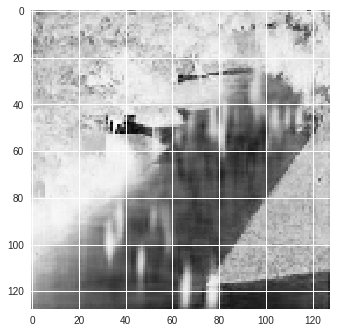

In [18]:
plt.imshow(np.squeeze(decode_imgs[1][1], axis = 2))
  

In [10]:
autoencoder.evaluate(test_cuboid, test_cuboid)


185/185 [==============================] - 8s 44ms/step


0.003987820723370926

In [0]:
import pydot
import graphviz
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png',show_shapes=True)

In [0]:
!apt-get install -q graphviz

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
